In [1]:
import tensorflow as tf
import requests
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from src.plotter.Plotter import Plotter
from src.maths.Error import r_squared
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
plt.rcParams.update({'font.size' : 16})
%matplotlib qt

In [2]:
gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=512)]
)

In [3]:
R = 8.31
M = 200.59e-3

critical_temperature = 1490+273.15
critical_pressure = 1510e5

In [4]:
data = requests.get('http://v5464.hosted-by-vdsina.com:8000/science/phases/?format=json&limit=1000').json()['results']
temperature = np.array([dat['temperature'] for dat in data])
pressure = np.array([dat['pressure'] for dat in data])
density = np.array([dat['density'] for dat in data])

saturation_data = requests.get('http://v5464.hosted-by-vdsina.com:8000/science/saturations/?format=json&limit=1000').json()['results']
saturation_temperature = np.array([dat['temperature'] for dat in saturation_data])
saturation_pressure = np.array([dat['pressure'] for dat in saturation_data])
saturation_density = np.array([dat['density'] for dat in saturation_data])

# pressure = np.log(pressure)
# density = np.log(density)

linearized_temperature = (temperature - min(temperature)) / (max(temperature) - min(temperature))
linearized_pressure = (pressure - min(pressure)) / (max(pressure) - min(pressure))
linearized_density = (density - min(density)) / (max(density) - min(density))

In [20]:
plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='3d')
plotter.scatter(temperature, pressure, density, s=30, color='b', alpha=0.5, label='Экспериментальные данные')
plotter.xlabel(r'$T$ $(K)$', labelpad=10, fontsize=18)
plotter.ylabel(r'$p$ $(Па)$', labelpad=10, fontsize=18)
plotter.zlabel(r'$\rho$ $(\dfrac {кг} {м^3})$', labelpad=10, fontsize=18)
plotter.legend()
plotter.show()

In [5]:
fig = plt.figure(layout='compressed', figsize=(7, 6))
ax = plt.axes(projection='3d')
ax.scatter(temperature, pressure, density, s=30, color='b', alpha=0.5, label='Экспериментальные данные')
ax.view_init(30, -60)
ax.set_xlabel(r'$T$ $(K)$', labelpad=10, fontsize=18)
ax.set_ylabel(r'$p$ $(Па)$', labelpad=10, fontsize=18)
ax.set_zlabel(r'$\rho$ $(\dfrac {кг} {м^3})$', labelpad=10, fontsize=18)
plt.legend()
def animate_func(num):
    ax.view_init(30, -60+num)

anim = FuncAnimation(fig, animate_func, interval=100, frames=360)
gif = PillowWriter(fps=30)
anim.save(r'D:\Учеба\Диплом\Figures\experimental_data_3d.gif', writer=gif)

In [30]:
plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='3d')
plotter.scatter(np.log(temperature), np.log(pressure), np.log(density), s=30, color='b', alpha=0.5, label='Экспериментальные данные')
plotter.xlabel(r'$ln(T)$', labelpad=10, fontsize=18)
plotter.ylabel(r'$ln(p)$', labelpad=10, fontsize=18)
plotter.zlabel(r'$ln(\rho)$', labelpad=10, fontsize=18)
plotter.legend()
plotter.show()

In [5]:
inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(10, activation='relu')(inputs)
x = tf.keras.layers.Dense(10, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MSE,
)

In [6]:
mask = np.arange(len(linearized_temperature))
np.random.shuffle(mask)

x_train = np.array([linearized_temperature[mask], linearized_pressure[mask]]).T
y_train = np.array([linearized_density[mask]]).T

fit = model.fit(x_train, y_train, epochs=150, validation_split=0.2, use_multiprocessing=True)

# with tf.device('/GPU:0'):
#     fit = model.fit(x_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/150
21/21 [==============================] - 3s 14ms/step - loss: 0.0375 - val_loss: 0.0240
Epoch 2/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0307 - val_loss: 0.0220
Epoch 3/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0278 - val_loss: 0.0198
Epoch 4/150
21/21 [==============================] - 0s 5ms/step - loss: 0.0251 - val_loss: 0.0183
Epoch 5/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0228 - val_loss: 0.0167
Epoch 6/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 0.0155
Epoch 7/150
21/21 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0139
Epoch 8/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0169 - val_loss: 0.0124
Epoch 9/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0111
Epoch 10/150
21/21 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0092
Epoch 11

In [48]:
loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.plot(range(len(loss)), loss, label='Ошибка обучающей выборки')
plotter.plot(range(len(val_loss)), val_loss, label='Ошибка валидационной выборки')
plotter.grid(True)
plt.legend()
plt.xlabel('Номер эпохи')
plt.ylabel('MSE ошибка')
plotter.show()

In [61]:
temperature_linspace = np.linspace(0, 1)
pressure_linspace = np.linspace(0, 1)
temperature_linspace, pressure_linspace = np.meshgrid(temperature_linspace, pressure_linspace)
shape = temperature_linspace.shape

x_test = np.array([temperature_linspace.flatten(), pressure_linspace.flatten()]).T
y_test = model.predict(x_test).T.reshape(shape)

r_x_test = np.array([linearized_temperature, linearized_pressure]).T
r_y_test = model.predict(r_x_test).T

r = r_squared(r_y_test, linearized_density)
r = np.round(r, 5)

plt.figure(layout='compressed', figsize=(7, 6))
ax = plt.axes(projection='3d')
ax.scatter(linearized_temperature, linearized_pressure, linearized_density, s=40, color='#333333', label='Экспериментальные данные')
surface = ax.plot_surface(temperature_linspace, pressure_linspace, y_test, cmap='jet', label='Нейросетевое уравнение состояния \n' + r'$R^2=%r$' %r)
ax.set_xlabel(r'$T_n$', labelpad=10)
ax.set_ylabel(r'$p_n$', labelpad=10)
ax.set_zlabel(r'$\rho_n$', labelpad=10)
plt.colorbar(surface, ax=ax, label=r'$\rho_n$', shrink=0.75, pad=0.15)
plt.legend(edgecolor='k')
plt.show()

# linear_x = np.linspace(0, 1, 100)
# linear_y = linear_x
# 
# plotter = Plotter(dimension='2d')
# plotter.scatter(linearized_density, y_test, alpha=0.5)
# plotter.plot(linear_x, linear_y, 'b-')
# plotter.xlabel(r'$Experimental$ $data$')
# plotter.ylabel(r'$Predicted$ $data$')
# plotter.grid(True)
# plotter.show()

26/26 [==============================] - 0s 3ms/step


In [49]:
Z = pressure * M / (R * temperature)

x_test = np.array([linearized_temperature, linearized_pressure]).T
y_test = model.predict(x_test).T * (max(density) - min(density)) + min(density)

plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.scatter(density, y_test, color='b', alpha=0.5)
plotter.plot(density, density, color='r', label='y(x)=x')
plotter.grid(True)
plotter.legend(edgecolor='k')
plotter.xlabel(r'$\rho_{эксп}$ $(\dfrac {кг} {м^3})$')
plotter.ylabel(r'$\rho_{нейро}$ $(\dfrac {кг} {м^3})$')
plotter.show()

26/26 [==============================] - 0s 2ms/step


In [27]:
log_temperature = np.log(temperature)
log_pressure = np.log(pressure)
log_density = np.log(density)

log_temperature_linearized = (log_temperature - min(log_temperature)) / (max(log_temperature) - min(log_temperature))
log_pressure_linearized = (log_pressure - min(log_pressure)) / (max(log_pressure) - min(log_pressure))
log_density_linearized = (log_density - min(log_density)) / (max(log_density) - min(log_density))

In [28]:
inputs = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(20, activation='gelu')(inputs)
x = tf.keras.layers.Dense(20, activation='gelu')(x)
outputs = tf.keras.layers.Dense(1, activation='linear')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.MSE,
)

mask = np.arange(len(linearized_temperature))
np.random.shuffle(mask)

x_train = np.array([log_temperature_linearized[mask], log_pressure_linearized[mask]]).T
y_train = np.array([log_density_linearized[mask]]).T

fit = model.fit(x_train, y_train, epochs=200, validation_split=0.2, use_multiprocessing=True)

Epoch 1/200
21/21 [==============================] - 3s 29ms/step - loss: 0.1561 - val_loss: 0.0836
Epoch 2/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0431 - val_loss: 0.0168
Epoch 3/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 4/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 5/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 6/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 7/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/200
21/21 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/200
21/21 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 9.9794e-04
Epoch 10/200
21/21 [==============================] - 0s 6ms/step - loss: 6.4908e-04 - val_loss: 5.1685e

In [40]:
loss = fit.history['loss']
val_loss = fit.history['val_loss']

plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.plot(range(len(loss)), loss, label='Ошибка обучающей выборки')
plotter.plot(range(len(val_loss)), val_loss, label='Ошибка валидационной выборки')
# plotter.grid(True)
plt.legend()
plt.xlabel('Номер эпохи')
plt.ylabel('MSE ошибка')
plotter.show()

In [37]:
temperature_linspace = np.linspace(min(temperature), max(temperature), 50)
pressure_linspace = np.linspace(min(pressure), max(pressure), 50)
temperature_linspace, pressure_linspace = np.meshgrid(temperature_linspace, pressure_linspace)
log_temperature_linspace = np.log(temperature_linspace)
log_pressure_linspace = np.log(pressure_linspace)
log_temperature_linspace_linearized = (log_temperature_linspace - np.min(log_temperature_linspace)) / (np.max(log_temperature_linspace) - np.min(log_temperature_linspace))
log_pressure_linspace_linearized = (log_pressure_linspace - np.min(log_pressure_linspace)) / (np.max(log_pressure_linspace) - np.min(log_pressure_linspace))

x_test = np.array([log_temperature_linspace_linearized.flatten(), log_pressure_linspace_linearized.flatten()]).T
y_test = np.exp(model.predict(x_test).T * (max(log_density) - min(log_density)) + min(log_density)).reshape(50, 50)

r_x_test = np.array([log_temperature_linearized, log_pressure_linearized]).T
r_y_test = np.exp(model.predict(r_x_test).T * (max(log_density) - min(log_density)) + min(log_density))

r = r_squared(r_y_test, density)
r = np.round(r, 5)

plt.figure(layout='compressed', figsize=(8, 7))
ax = plt.axes(projection='3d')
ax.scatter(temperature, pressure, density, s=40, color='#333333', label='Экспериментальные данные')
surface = ax.plot_surface(temperature_linspace, pressure_linspace, y_test-1, cmap='jet', label='Нейросетевое уравнение состояния \n' + '$R^2=%r$' %r, alpha=1)
ax.set_xlabel(r'$T (K)$', labelpad=10)
ax.set_ylabel(r'$p (Pa)$', labelpad=10)
ax.set_zlabel(r'$\rho$ $(кг/м^3)$', labelpad=10)
plt.legend()
plt.colorbar(surface, ax=ax, label=r'$\rho$ $(кг/м^3)$', shrink=0.75, pad=0.15)
plt.show()

26/26 [==============================] - 0s 3ms/step


In [75]:
shape

(50, 50)

In [55]:
Z = pressure * M / (R * temperature)

r = r_squared(r_y_test, density)
r = np.round(r, 4)
plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.scatter(density, r_y_test, color='b', alpha=0.5, s=50)
plotter.plot(density, density, color='r', label='y(x)=x, $R^2=%r$' %r)
plotter.grid(True)
plotter.legend(edgecolor='k')
plotter.xlabel(r'$\rho_{эксп}$ $(\dfrac {кг} {м^3})$')
plotter.ylabel(r'$\rho_{нейро}$ $(\dfrac {кг} {м^3})$')
plotter.show()

<h2 align='center'>Mass difference in Equation of state</h2>

In [6]:
Z = pressure * M / (R * temperature)

sort_mask = np.lexsort((temperature, pressure, density))
mask1 = (density < 200) & (density > 0)
mask2 = (density < 2000) & (density > 200)

lin_func_1 = lambda x: x
lin_func_2 = lambda x, a, b: a * x + b
# lin_popt_1, _ = curve_fit(lin_func_1, density[mask1], Z[mask1])
lin_popt_2, _ = curve_fit(lin_func_2, density[mask2], Z[mask2])
# lin_popt_1 = np.round(lin_popt_1, 4)
lin_popt_2 = np.round(lin_popt_2, 4)

par_func_1 = lambda x, a: a * x ** 2 + x
par_popt_1, _ = curve_fit(par_func_1, density, Z)
par_popt_1 = np.round(par_popt_1, 4)

# func = lambda x, a, b: a * x + b
# func2 = lambda x, a, b, c: a * x ** 2 + b * x + c
# test_func = lambda x: -25/1e5 * x ** 2 + x
# test_func2 = lambda x, a, b, c: a * np.log(x + b) + c
# popt1, pcov1 = curve_fit(func, density[mask1], Z[mask1])
# popt2, pcov2 = curve_fit(func, density[mask2], Z[mask2])
# popt3, pcov3 = curve_fit(func2, density[sort_mask], Z[sort_mask])
# popt4, pcov4 = curve_fit(test_func2, density[sort_mask], Z[sort_mask])

In [7]:
def equation_of_state_1(x):
    return x[x <= 200] - (lin_popt_2[0] * x[x >= 200] + lin_popt_2[1])

def equation_of_state(x):
    return x + np.tanh(x / 200)*((lin_popt_2[0] - 1) * x + lin_popt_2[1])

In [42]:
plt.figure(layout='compressed', figsize=(7, 6))
plotter = Plotter(dimension='2d')
plotter.scatter(density, Z, color='b', alpha=0.5, s=50, label='Экспериментальные данные')

# r = r_squared(Z, density)
# r = np.round(r, 5)
# plotter.plot([min(density), max(density)], [min(density), max(density)], label=rf'Ideal gas equation of state $R^2={r}$')

# x = density[mask1]
# y = lin_func_1(x)
# r1 = r_squared(y, Z[mask1])
# r1 = np.round(r1, 5)
# plotter.plot(x, y,'r-')
# 
# x = density[mask2]
# y = lin_func_2(x, *lin_popt_2)
# r2 = r_squared(y, Z[mask2])
# r2 = np.round(r2, 5)
# plotter.plot(x, y, 'g-')

x = density[sort_mask]
y = par_func_1(x, *par_popt_1)
r = r_squared(y, Z[sort_mask])
r = np.round(r, 5)
plotter.plot(x, y, 'r-', label=rf'$y(x)={par_popt_1[0]} \bullet x^2 + x$, $R^2={r}$')

# plotter.plot(
#     density[sort_mask], 
#     equation_of_state(density[sort_mask]),
#     'c-', 
#     label='Our equation of state'
# )

# plt.annotate(
#     r'$y(x)=x$' + '\n' + f'$R^2={r1}$', 
#     xy=(100, 100), xytext=(120, 10),
#     arrowprops={'facecolor': 'black', 'shrink' : 0.05}
# )
# plt.annotate(
#     rf'$y(x)={lin_popt_2[0]}x + {lin_popt_2[1]}$' + '\n' + f'$R^2={r2}$', 
#     xy=(295, 270), xytext=(0, 300), 
#     arrowprops={'facecolor': 'black', 'shrink' : 0.05}
# )

plotter.xlabel(r'$\rho$ $(кг/м^3)$')
plotter.ylabel(r'$p \mu /(RT)$ $(кг/м^3)$')
plotter.legend(edgecolor='k')
# plotter.grid(True)
plotter.show()

In [44]:
plotter = Plotter(dimension='2d')
plotter.scatter(density, density - Z)
plotter.show()

<h2 align='center'>The transition line</h2>

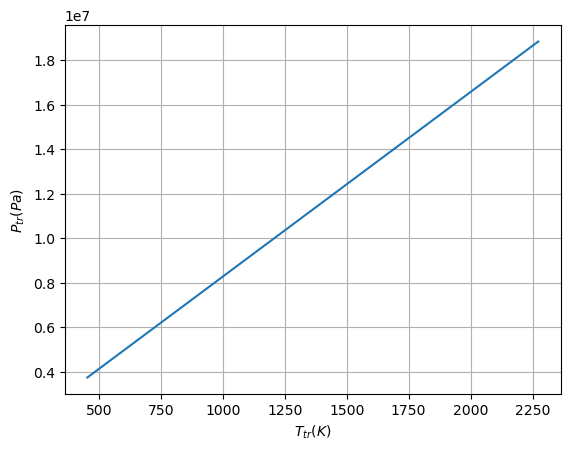

In [8]:
p_tr = 200 * R * temperature / M

plotter = Plotter(dimension='2d')
plotter.plot(temperature, p_tr)
plotter.xlabel(r'$T_{tr} (K)$')
plotter.ylabel(r'$P_{tr} (Pa)$')
plotter.grid(True)
plotter.show()

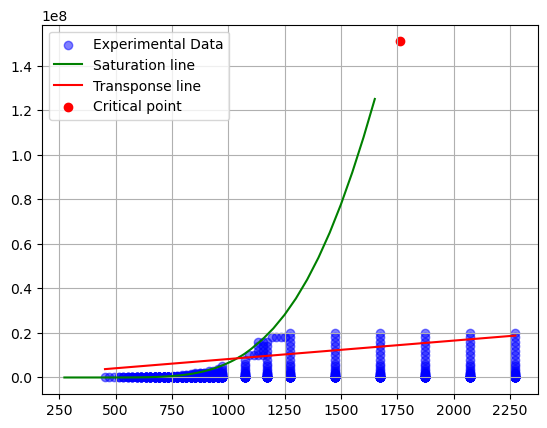

In [9]:
sort_mask = np.lexsort((temperature, pressure))
saturaion_sort_mask = np.lexsort((saturation_temperature, saturation_pressure))

plotter = Plotter(dimension='2d')
plotter.scatter(temperature[sort_mask], pressure[sort_mask], color='b', alpha=0.5, label='Experimental Data')
plotter.plot(saturation_temperature[saturaion_sort_mask], saturation_pressure[saturaion_sort_mask], 'g-', label='Saturation line')
plotter.plot(temperature, p_tr, 'r-', label='Transponse line')
plotter.scatter(1490+273.15, 1510e5, color='r', label='Critical point')
plotter.grid(True)
plotter.legend()
plotter.show()

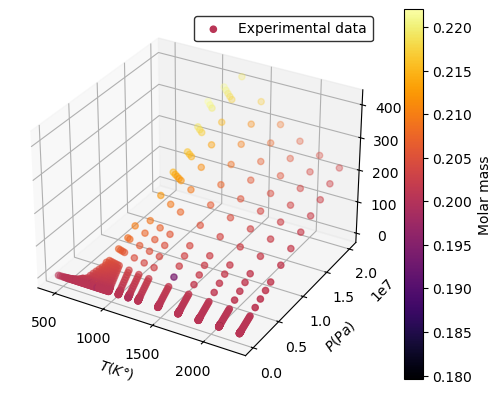

In [10]:
temp = R * temperature * density / pressure

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(temperature, pressure, density, c=temp, cmap='inferno', label='Experimental data')
ax.legend(edgecolor='k')
ax.set_xlabel(r'$T (K \degree)$')
ax.set_ylabel(r'$P (Pa)$')
ax.set_zlabel(r'$\rho (kg/m^3)$')
plt.colorbar(scatter, label='Molar mass')
plt.show()

<h2 align='center'>$M(\rho)$</h2>

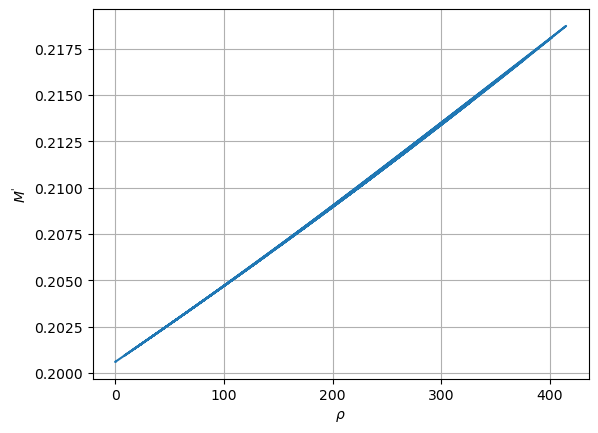

In [11]:
plotter = Plotter(dimension='2d')
plotter.plot(density[sort_mask], M / (par_popt_1[0] * density[sort_mask] + 1))
plotter.xlabel(r'$\rho$')
plotter.ylabel(r"$M^'$")
plotter.grid(True)
plotter.show()

<h2 align='center'> The saturation line</h2>

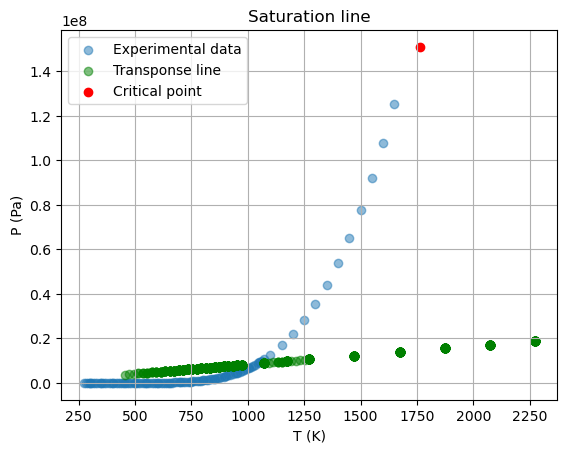

In [12]:
plotter = Plotter(dimension='2d')
plotter.title('Saturation line')
plotter.scatter(saturation_temperature, saturation_pressure, alpha=0.5, label='Experimental data')
plotter.scatter(temperature, p_tr, color='g', alpha=0.5, label='Transponse line')
plotter.scatter(1490+273.15, 1510e5, color='r', label='Critical point')
plotter.xlabel('T (K)')
plotter.ylabel('P (Pa)')
plotter.grid(True)
plotter.legend()
plotter.show()

In [5]:
def saturation_func(x, a, b):
    return a * x + b


def saturation_line(tau, a_1, a_2, a_3, a_4, a_5, a_6):
    return 1/tau * (a_1 * (1-tau) + a_2 * (1-tau) ** 1.5 + a_3 * (1-tau) ** 3 + a_4 * (1-tau) ** 3.5 + a_5 * (1-tau) ** 4 + a_6 * (1-tau) ** 7.5)


saturation_sort_mask = np.lexsort((saturation_temperature, saturation_pressure, saturation_density))

tau = saturation_temperature / critical_temperature
pheta = saturation_pressure / critical_pressure
sat_popt, sat_pcov = curve_fit(saturation_line, tau, np.log(pheta))
print(sat_popt)

adjusted_saturation_temperature = critical_temperature / saturation_temperature
adjusted_saturation_pressure = saturation_pressure / critical_pressure

saturation_popt, saturation_pcov = curve_fit(saturation_func, adjusted_saturation_temperature, np.log(adjusted_saturation_pressure))
saturation_popt = np.round(saturation_popt, 2)


saturation_temperature_lin = np.linspace(270, critical_temperature, 100)

plotter = Plotter(dimension='2d')
plotter.scatter(saturation_temperature, saturation_pressure, alpha=0.5, label='Experimental data')

x = saturation_temperature_lin
y = np.exp(saturation_func(critical_temperature/saturation_temperature_lin, *saturation_popt)) * critical_pressure
y_1 = np.exp(saturation_func(critical_temperature/saturation_temperature, *saturation_popt)) * critical_pressure
r = r_squared(y_1, saturation_pressure)
r = np.round(r, 4)
plotter.plot(x, y, 'r--', label=fr'Our equation $R^2={r}$')

x = saturation_temperature_lin
y = np.exp(saturation_line(saturation_temperature_lin / critical_temperature, *sat_popt)) * critical_pressure
y_1 = np.exp(saturation_line(saturation_temperature / critical_temperature, *sat_popt)) * critical_pressure
r = r_squared(y_1, saturation_pressure)
r = np.round(r, 4)
plotter.plot(x, y, 'b-', label=fr'Known equation $R^2={r}$')

plotter.scatter(critical_temperature, critical_pressure, color='r', label='Critical point')
plotter.xlabel('$T(K)$')
plotter.ylabel('$P(Pa)$')
plotter.legend()
plotter.grid(True)
plotter.show()

[  -0.67720295   -9.69409424   64.75474773 -107.20004043   49.77182408
   -1.28959448]


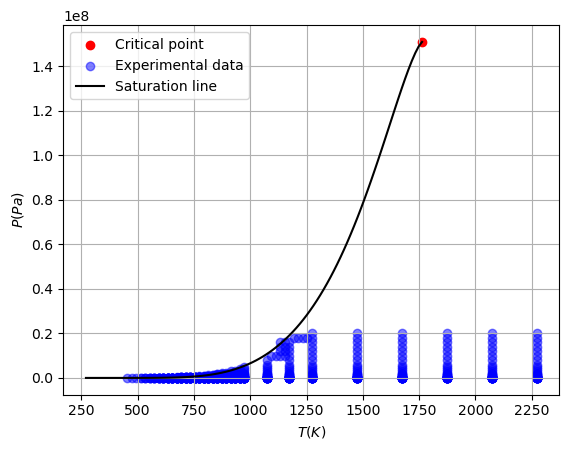

In [14]:
plotter = Plotter(dimension='2d')
plotter.scatter(critical_temperature, critical_pressure, color='r', label='Critical point')
plotter.scatter(temperature, pressure, color='b', alpha=0.5, label='Experimental data')
plotter.plot(saturation_temperature_lin, np.exp(saturation_line(saturation_temperature_lin / critical_temperature, *sat_popt)) * critical_pressure, 'k-', label='Saturation line')
plotter.grid(True)
plotter.xlabel('$T(K)$')
plotter.ylabel('$P(Pa)$')
plotter.legend()
plotter.show()

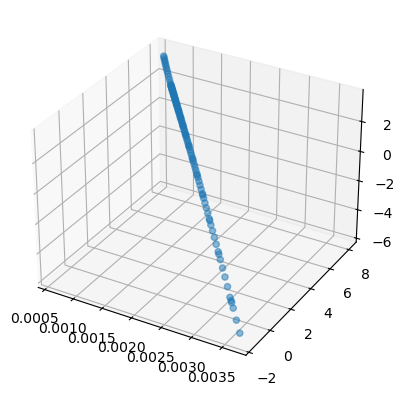

In [15]:
plotter = Plotter(dimension='3d')
plotter.scatter(1/saturation_temperature, np.log10(saturation_pressure), np.log10(saturation_density), alpha=0.5)
plotter.show()

<h2 align='center'>Known equation of saturation line</h2>

[  -0.67720295   -9.69409424   64.75474773 -107.20004043   49.77182408
   -1.28959448]


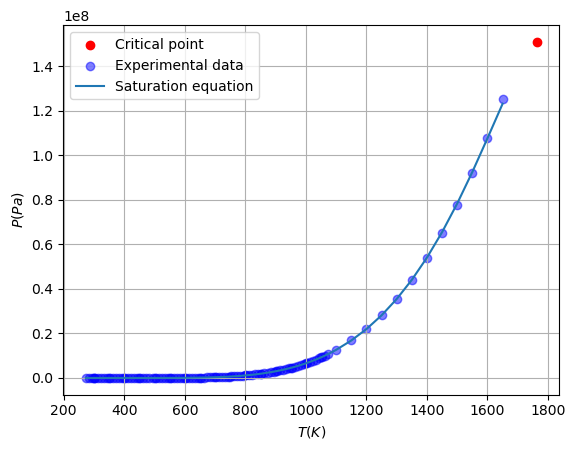

In [16]:
saturation_sort_mask = np.lexsort((saturation_temperature, saturation_pressure, saturation_density))
critical_temperature = 1490+273.15
critical_pressure = 1510e5

def saturation_line(tau, a_1, a_2, a_3, a_4, a_5, a_6):
    return 1/tau * (a_1 * (1-tau) + a_2 * (1-tau) ** 1.5 + a_3 * (1-tau) ** 3 + a_4 * (1-tau) ** 3.5 + a_5 * (1-tau) ** 4 + a_6 * (1-tau) ** 7.5)


tau = saturation_temperature / critical_temperature
pheta = saturation_pressure / critical_pressure
sat_popt, sat_pcov = curve_fit(saturation_line, tau, np.log(pheta))
print(sat_popt)


plotter = Plotter(dimension='2d')
plotter.scatter(critical_temperature, critical_pressure, color='r', label='Critical point')
plotter.scatter(saturation_temperature, saturation_pressure, color='b', alpha=0.5, label='Experimental data')
plotter.plot(saturation_temperature[saturation_sort_mask], np.exp(saturation_line(tau[saturation_sort_mask], *sat_popt)) * critical_pressure, label='Saturation equation')
plotter.xlabel(r'$T(K)$')
plotter.ylabel(r'$P(Pa)$')
plotter.legend()
plotter.grid(True)
plotter.show()


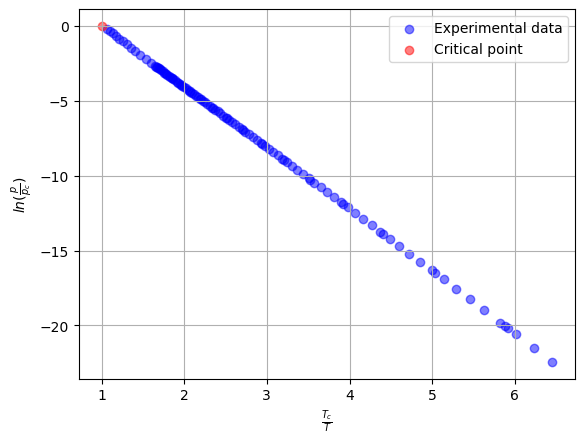

In [17]:
derived_temperature = saturation_temperature / critical_temperature
derived_pressure = saturation_pressure / critical_pressure

plotter = Plotter(dimension='2d')
plotter.scatter(1/derived_temperature, np.log(derived_pressure), color='b', alpha=0.5, label='Experimental data')
plotter.scatter(1, 0, color='r', alpha=0.5, label='Critical point')
plotter.xlabel(r'$\frac{T_c}{T}$')
plotter.ylabel(r'$ln(\frac{p}{p_c})$')
plotter.legend()
plotter.grid(True)
plotter.show()

<h2 align='center'>State</h2>

In [32]:
def plane(xy, A, B, C):
    x, y = xy
    return A*x + B*y + C


temperature_log = np.log(temperature)
pressure_log = np.log(pressure)
density_log = np.log(density)

plane_popt, plane_pcov = curve_fit(plane, (temperature_log, pressure_log), density_log)
plane_x = np.linspace(min(temperature_log), max(temperature_log), 100)
plane_y = np.linspace(min(pressure_log), max(pressure_log), 100)
plane_x, plane_y = np.meshgrid(plane_x, plane_y)
plane_z = plane((plane_x, plane_y), *plane_popt)


r = r_squared(plane((temperature_log, pressure_log), *plane_popt), density_log)
r = np.round(r, 4)

plotter = Plotter(dimension='3d')
plotter.scatter(np.log(temperature), np.log(pressure), np.log(density), color='b', alpha=1, label=fr'Experimental data')
plotter.plot_wireframe(plane_x, plane_y, plane_z, color='m', label=fr'Equation of state, $R^2={r}$')
plotter.xlabel(r'$ln(T)$')
plotter.ylabel(r'$ln(P)$')
plotter.zlabel(r'$ln(\rho)$')
plotter.legend()
plotter.show()
plane_popt

array([-1.00661982,  1.00440378, -3.72534209])

In [58]:
plotter = Plotter(dimension='3d')
plotter.scatter(temperature, pressure, density, color='b', alpha=1, label=fr'Experimental data')

r = r_squared(plane(np.exp((temperature_log, pressure_log)), *plane_popt), density)
r = np.round(r, 4)
plotter.plot_wireframe(np.exp(plane_x), np.exp(plane_y), np.exp(plane_z), color='m', label=fr'Equation of state, $R^2={r}$')

plotter.xlabel(r'$T(K)$')
plotter.ylabel(r'$P(Pa)$')
plotter.zlabel(r'$\rho(kg/m^3)$')
plotter.legend()
plotter.show()

In [59]:
M / R * np.exp(3.725)

1.0010486854735983

<h2 align='center'>Viral equation of state</h2>

In [79]:
def viral_equation(x, b_2):
    return x + b_2 * x ** 2


temperature_set = sorted(set(temperature))
popt = []
error = []
viral_Z = []
temperatures = []
Z = pressure * M / (R * temperature)
i = -1
for temp in temperature_set:
    i += 1
    temp_mask = (temperature == temp)
    temp_density = density[temp_mask]
    temp_Z = Z[temp_mask]
    # 
    # if len(temp_Z) < 15:
    #     continue
    
    viral_popt, viral_pcov = curve_fit(viral_equation, temp_density, temp_Z)
    if viral_pcov[0] == np.inf:
        continue
    viral_Z.append(viral_equation(temp_density, *viral_popt))
    popt.append(viral_popt[0])
    error.append(np.sqrt(np.diag(viral_pcov))[0])
    temperatures.append(temp)

popt = np.array(popt)
error = np.array(error)

fig = plt.figure()
plt.scatter(temperatures, popt)
plt.plot(temperatures, popt - error, color='k')
plt.plot(temperatures, popt + error, color='k')
plt.fill_between(temperatures, popt - error, popt + error, alpha=0.15)
plt.xlabel(rf'$T(K)$')
plt.ylabel(rf'$B_2$')
plt.grid(True)
plt.show()

C:\Users\glebf\.conda\envs\tf\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [78]:
error

array([3.66031980e-04, 2.08761161e-04, 1.05024991e-04, 6.09381552e-05,
       3.16805786e-05, 2.03963197e-05, 1.26402471e-05, 1.06112165e-05,
       6.68803417e-06, 4.13415896e-06, 3.96855031e-06, 3.84146312e-06,
       3.43407578e-06, 2.34375209e-06, 1.65972661e-06, 1.22812611e-06,
       9.57867858e-07, 4.33108981e-06, 5.78303520e-07, 5.87356142e-07,
       4.83791633e-07, 5.21660999e-07, 3.39909460e-07, 2.22866480e-07,
       1.06158190e-07, 6.42121242e-07, 6.12300140e-07, 1.88162809e-07,
       2.05523629e-07, 1.12305168e-07, 8.36499538e-08, 5.72698439e-07,
       5.97058900e-08, 7.11075219e-08])

In [28]:
plotter = Plotter(dimension='2d')
for index, temp in enumerate(temperature_set):
    temp_mask = (temperature == temp)
    temp_Z = Z[temp_mask]
    plotter.scatter(temp_Z, viral_Z[index], color='b')
plotter.xlabel(r'$\rho_{exp}$')
plotter.ylabel(r'$\rho_{viral}$')
plotter.grid(True)
plotter.show()

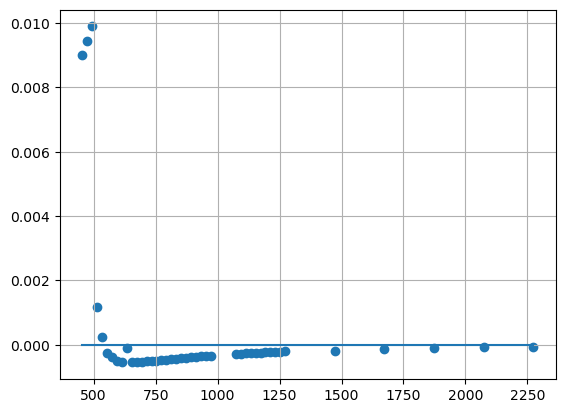

In [27]:
def viral_coeff_plot(x, a, b):
    return (a / x) ** 12 - (b / x) ** 6

temperature_set = np.array(temperature_set)
popt = np.array(popt)
viral_popt, viral_pcov = curve_fit(viral_coeff_plot, temperature_set, popt)

plotter = Plotter(dimension='2d')
plotter.scatter(temperature_set, popt)
plotter.plot(temperature_set, viral_coeff_plot(temperature_set, *viral_popt))
plotter.grid(True)
plotter.show()

<h2 align='center'>Approximate experimental data</h2>

In [34]:
def fit_equation(xy, a, b, c):
    x, y = xy
    return a * x + b * y + c


fit_popt, fit_pcov = curve_fit(fit_equation, [np.log(temperature), np.log(pressure)], np.log(density))

x_linspace = np.linspace(min(np.log(temperature)), max(np.log(temperature)), 100)
y_linspace = np.linspace(min(np.log(pressure)), max(np.log(pressure)), 100)
x_linspace, y_linspace = np.meshgrid(x_linspace, y_linspace)
z_linspace = fit_equation([x_linspace, y_linspace], *fit_popt)

r = r_squared(fit_equation((np.log(temperature), np.log(pressure)), *fit_popt), np.log(density))
r = np.round(r, 4)

fig = plt.figure(figsize=(8, 8), layout='compressed')
ax = plt.axes(projection='3d')
ax.scatter(np.log(temperature), np.log(pressure), np.log(density), label='Экспериментальные данные', color='#333333', s=30)
surface = ax.plot_surface(x_linspace, y_linspace, z_linspace, cmap='jet', alpha=1, label='Уравнение состояния $R^2=%s$' %r)
plt.colorbar(surface, ax=ax, label=r'$ln(\rho)$', shrink=0.75, pad=0.15)
ax.set_xlabel(r'$ln(T)$', labelpad=10, fontsize=18)
ax.set_ylabel(r'$ln(p)$', labelpad=10, fontsize=18)
ax.set_zlabel(r'$ln(\rho)$', labelpad=10, fontsize=18)
plt.legend()
plt.show()
plt.savefig(r'D:\Учеба\Диплом\Figures\idealGasFittingLinearized.png')

In [36]:
r = r_squared(np.exp(fit_equation((np.log(temperature), np.log(pressure)), *fit_popt)), density)
r = np.round(r, 4)

fig = plt.figure(figsize=(8, 8), layout='compressed')
ax = plt.axes(projection='3d')
ax.scatter(temperature, pressure, density, label='Экспериментальные данные', color='#333333', s=30)
surface = ax.plot_surface(np.exp(x_linspace), np.exp(y_linspace), np.exp(z_linspace), cmap='jet', alpha=1, label='Уравнение состояния $R^2=%s$' %r)
plt.colorbar(surface, ax=ax, label=r'$\rho$ $(\dfrac {кг} {м^3})$', shrink=0.75, pad=0.15)
ax.set_xlabel(r'$T$ $(K)$', labelpad=12, fontsize=18)
ax.set_ylabel(r'$p$ $(Па)$', labelpad=12, fontsize=18)
ax.set_zlabel(r'$\rho$ $(\dfrac {кг} {м^3})$', labelpad=14, fontsize=18)
plt.legend()
plt.show()
plt.savefig(r'D:\Учеба\Диплом\Figures\idealGasFitting.png')

<h2 align='center'>Matplotlib settings</h2>

In [21]:
%matplotlib inline

In [22]:
%matplotlib qt

In [106]:
print(plane_popt)

[-1.00730751  1.00446963 -3.72152391]
